# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Advanced Topics in Data Science

## **Classifying Bird Sounds From Around the World**


**Harvard University**<br/>
**Spring 2024**<br/>
**Instructors**: Pavlos Protopapas<br/>
**Project Members**: Elianne Sacher, Shane Kissinger, and Oleg Pavliv

In [7]:
# RUN THIS CELL
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

In [8]:
# Import libraries
import requests
import zipfile
import io, os
import pickle
import gc

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import scipy as sp
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import sklearn as sk
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Activation, BatchNormalization, Flatten, Dropout, GaussianNoise, RandomContrast, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import Precision, Recall, F1Score
import tensorflow as tf

from PIL import Image
from io import BytesIO

import warnings
# Suppress specific FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore")
gc.collect()

1282

In [15]:
"""Helper Functions"""

def plot_history(history):
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    axs[0].plot(history.history["acc"])
    axs[0].plot(history.history["val_acc"])
    axs[0].set_title('model acc')
    axs[0].set_ylabel('acc')
    axs[0].set_xlabel('epoch')
    
    # summarize history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('model loss')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')

    best_acc = np.nanmax(history.history['val_acc'])
    print(f"Best validation acc at epoch: {np.argmax(history.history['val_acc'])}")
    print(f"Best validation loss at epoch: {np.argmin(history.history['val_loss'])}")
    axs[0].axvline(np.nanargmax(history.history['val_acc']),
                c='k', ls='--')
    
    best_loss = np.nanmin(history.history['val_loss'])
    axs[1].axvline(np.nanargmin(history.history['val_loss']),
                c='k', ls='--')

    axs[0].legend(['train', 'validation', f'best val acc = {best_acc:.3f}'])
    axs[1].legend(['train', 'validation', f'best val loss = {best_loss:.3f}'], loc='upper left')

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

<a id="contents"></a>

## **Notebook contents**

- [**Final Model**](#model)
    - [**Evolution of our Model**](#model)
    - [**Final Model Implementation**](#model)
- [**Evaluation**](#Eval)
- [**Conclusions and Next Steps**](#conc)

<a id="model"></a>

## **Final Model**

### **Evolution of Our Model**

In the development of our machine learning model for classifying bird sounds, we experienced several phases of iteration and refinement aimed at improving our model's accuracy and efficiency. Here is a summary of how our model evolved:

#### Initial Approach: Down-Sampled Spectrogram Data
Our initial approach involved training the model on down-sampled versions of spectrogram images from all available bird species. This approach aimed to manage the vast amount of data by reducing its dimensionality. However, this method resulted in a significantly reduced model accuracy, achieving well under 50%. The primary issues identified were the loss of crucial information due to downsampling and class imbalances across the dataset.

#### Refinement: Focusing on Top 10 Common Species
To address the shortcomings of our initial model, we shifted our focus to the 10 most common bird species, training on their spectrogram images without downsampling. This strategy improved the quality of the data fed into the model by preserving more detailed features in the spectrograms. Despite these improvements, the model's performance stagnated at around 70% accuracy. We attributed this plateau to persistent issues with class imbalances, where the model favored more common species.

#### Targeted Strategy: Top 5 Common Species with Enhanced Audio Preprocessing
To further refine our approach, we decided to narrow our focus to the five most common species. Importantly, instead of relying solely on spectrogram images, we chose to train directly on the audio data. This shift allowed us to implement more sophisticated audio preprocessing techniques:
- **Amplitude Normalization:** We normalized the amplitude of audio recordings to standardize the volume across all samples, ensuring consistent input levels for our model.
- **Silence Removal:** We removed silent segments from the recordings to concentrate the model’s learning on relevant audio cues.
- **Segmentation:** We chopped audio into 10-second segments. This not only increased the number of samples available for each recording but also allowed us to manage class imbalances more effectively by reducing the number of segments from over-represented species without losing valuable data from under-represented ones.

This approach dramatically increased the diversity and quality of the training data. By focusing on fewer species and enhancing our preprocessing pipeline, we could train a more robust model that better recognized distinct audio patterns characteristic of different bird species.

*Note that we chose 5 species given the memory constraints of our free VM.*

#### Transfer Learning Attempt
In addition to these strategies, we experimented with transfer learning using the WAV2VEC2.0 model, as detailed in another notebook. However, we found that the computational demands were excessively high, leading to impractically long training times without commensurate gains in performance.
ns in performance.

### **Final Model Implementation**

<img src="model.jpg" width="500" height="300" alt="model">


In [10]:
batch_size = 32
target_size = (370, 969)

directory = "./generated_spectrograms_balanced_gray"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

traingen = datagen.flow_from_directory(
                                directory,  
                                target_size=target_size, 
                                batch_size=batch_size,
                                class_mode='categorical', 
                                shuffle=True,
                                color_mode='grayscale',
                                subset='training')

valgen = datagen.flow_from_directory(
                                directory,  
                                target_size=target_size, 
                                batch_size=batch_size,
                                class_mode='categorical', 
                                shuffle=False,
                                color_mode='grayscale',
                                subset='validation')

Found 12034 images belonging to 5 classes.
Found 3005 images belonging to 5 classes.


In [11]:
def init_model(input_shape, num_labels, activation="relu", dropout_rate=0.5):
    inputs = Input(shape=input_shape)
    # Data Augmentation
    x = tf.keras.layers.GaussianNoise(0.2)(inputs)
    x = tf.keras.layers.RandomTranslation(
        height_factor=0.01,
        width_factor=0.10,
        fill_mode='wrap'
    )(x)
    # Simplified convolutional block
    x = Conv2D(32, (3, 3), padding="valid", activation=activation)(inputs)
    x = MaxPool2D(2)(x)
    x = Conv2D(32, (3, 3), padding="same", activation=activation)(x)
    x = MaxPool2D(2)(x)
    x = Conv2D(32, (3, 3), padding="same", activation=activation)(x)
    x = MaxPool2D(2)(x)
    x = Conv2D(32, (3, 3), padding="same", activation=activation)(x)
    x = MaxPool2D(2)(x)
    x = Conv2D(32, (3, 3), padding="same", activation=activation)(x) # added
    x = MaxPool2D(2)(x)
    
    # Flatten the output
    flat = Flatten()(x)

    # Dense layer with batch normalization and dropout
    x = Dense(
        units=64, 
        activation=None, 
    )(flat)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(units=64, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dropout_rate)(x)
    
    # Output layer with softmax activation
    outputs = Dense(units=num_labels, activation="softmax")(x)

    return Model(inputs=[inputs], outputs=[outputs])

input_shape = (target_size[0],target_size[1],1)
model = init_model(input_shape, num_labels=5) 
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 370, 969, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 368, 967, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 184, 483, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 184, 483, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 92, 241, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 92, 241, 32)       9248

In [12]:
%time

model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=['acc',f1_m,precision_m, recall_m])
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    traingen,
    epochs=30,
    validation_data=valgen,
    callbacks=[es]
)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs
Epoch 1/30
377/377 [==============================] - 188s 474ms/step - loss: 1.4388 - acc: 0.4168 - f1_m: 0.3374 - precision_m: 0.5540 - recall_m: 0.2454 - val_loss: 1.4012 - val_acc: 0.4722 - val_f1_m: 0.0045 - val_precision_m: 0.0532 - val_recall_m: 0.0024
Epoch 2/30
377/377 [==============================] - 96s 254ms/step - loss: 1.1251 - acc: 0.5478 - f1_m: 0.4788 - precision_m: 0.7051 - recall_m: 0.3659 - val_loss: 0.9963 - val_acc: 0.6190 - val_f1_m: 0.4543 - val_precision_m: 0.7796 - val_recall_m: 0.3489
Epoch 3/30
377/377 [==============================] - 98s 259ms/step - loss: 0.9776 - acc: 0.6195 - f1_m: 0.5636 - precision_m: 0.7714 - recall_m: 0.4476 - val_loss: 0.9635 - val_acc: 0.6033 - val_f1_m: 0.5402 - val_precision_m: 0.7526 - val_recall_m: 0.4440
Epoch 4/30
377/377 [==============================] - 94s 248ms/step - loss: 0.8572 - acc: 0.6792 - f1_m: 0.6330 - precision_m: 0.8167 - recall_m: 0.5201 - va

## **Model Evaluation**

Best validation acc at epoch: 12
Best validation loss at epoch: 13


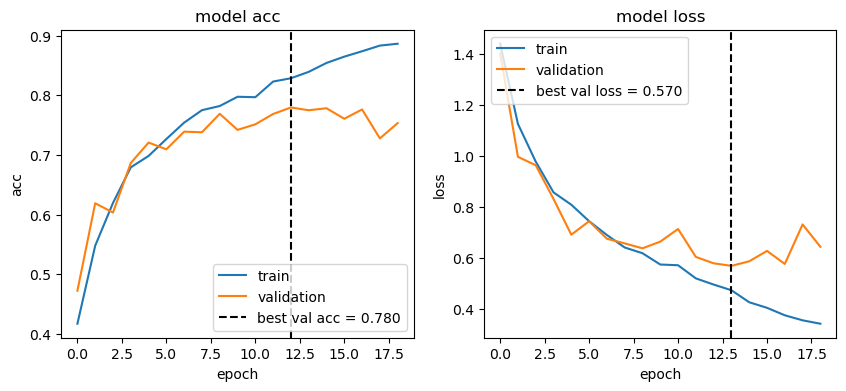

In [16]:
plot_history(history)

94/94 [==============================] - 17s 183ms/step


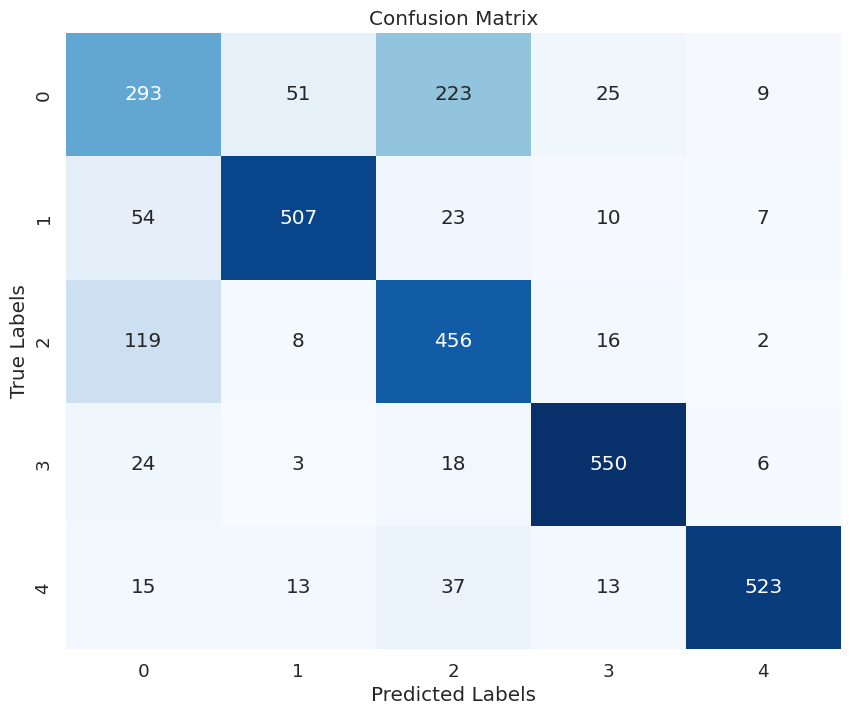

In [17]:
y_pred = model.predict(valgen)
y_true = valgen.labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Compared to our earlier iterations, the accuracy of our final model has shown a significant improvement. This enhancement is not just in terms of performance metrics but also in operational efficiency. Unlike the transfer learning model, which requires several hours to train, our current model completes its training and fits the data in less than an hour. This increase in efficiency does not compromise the model's effectiveness, as evident from the confusion matrix. The matrix indicates that we have successfully addressed the class imbalance issue that previously limited our model's predictive capabilities. There does seem to be an issue with classes 2 and 3, but overall it performs well. In our prior models, this imbalance created a ceiling on performance, causing certain classes to be predicted more frequently than others, irrespective of the actual data distribution. The adjustments in training strategy and data handling have effectively mitigated these concerns, leading to a more balanced and accurate classification across different bird species.

## **Conclusions and Next Steps**

### **Conclusion**

Throughout the progression of our project, we have successfully developed a machine learning model capable of classifying bird sounds with significantly improved accuracy. This achievement comes despite the computational limitations and the deliberate decision to exclude geographical metadata from our modeling process. Our final model not only operates efficiently—fitting data in under an hour—but also overcomes the class imbalance issues that hampered earlier versions.

### **Next Steps**

**Expanding the Model's Scope with Additional Resources:** One of the primary constraints we faced was the limited computational power of our personal computers, which restricted our ability to train the model on a larger variety of species and samples. Our preprocessing technique, which can generate at least ten clean spectrograms from a single soundbite, shows promise for undersampling the majority class while retaining sufficient data for effective training. With access to more powerful computational resources, it is feasible that we could extend our model to accurately classify more than the ten species currently supported.

**Incorporating Geographical Data:** We initially chose to exclude geo-tags to increase the complexity and general applicability of our model. This decision was aimed at ensuring the model's utility across diverse scenarios, independent of location-specific data. However, incorporating geo-tags could enhance the model’s accuracy by providing additional contextual information, although care must be taken to avoid over-relying on metadata at the expense of the acoustic features that should primarily drive the classification process.

**Exploring Transfer Learning:** The use of transfer learning has the potential to greatly enhance model performance by leveraging pre-trained networks. However, due to the extensive computation time required, we opted not to employ this technique extensively. If time and computational resources were less of a constraint, a future direction could involve a more thorough application of transfer learning techniques to see if they can offer a substantial improvement in performance without prohibitive increases in run-time.

These steps outline a path forward that could potentially elevate the project from a successful academic exercise to a more robust tool capable of broader application and greater scientific impact. By addressing these areas, future iterations of the project can not only refine the model’s performance but also expand its practical applicability to real-world conservation efforts.